## Statistical downscaling for extreme wave heights in the European North Sea

#### Sofia Davoli
#### Matricula: 813479

In [550]:
#libraries
import xarray as xr
import pandas as pd
import numpy as np
import geopandas
import shapely
from geopandas import gpd
from shapely.geometry import Point
from datetime import datetime
import cartopy.crs as ccrs
import seaborn as sns
from cartopy.feature import NaturalEarthFeature
import matplotlib.pyplot as plt
import os
from shapely.ops import nearest_points
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Conv1D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")

In [551]:
def plot_loss_accuracy(history):
    mpl.rcParams['figure.figsize'] = (6,4)
    plt.subplot(2,1,1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss %')
    plt.title('Loss')
    plt.legend(['Train','Validation'])
    plt.show()

    plt.subplot(2,1,2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy %')
    plt.title("Accuracy")
    plt.legend(['Train', 'Validation'])
    plt.show()
    
def plot_confusion_matrix(confusion_matrix, title):
    mpl.rcParams['figure.figsize'] = (6,4)
    ax= plt.subplot()
    sns.set(font_scale=1.4) # for label size
    group_names = ['True Pos','False Neg','False Pos','True Neg']
    group_counts = ["{0:0.0f}".format(value) for value in
                    confusion_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         confusion_matrix.flatten()/np.sum(confusion_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2,v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(confusion_matrix, annot=labels, fmt='', cmap='Blues',)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels') 
    ax.set_title(title)
    ax.xaxis.set_ticklabels([ ' Normal Waves',' Extreme Waves'])
    ax.yaxis.set_ticklabels([ ' Normal Waves',' Extreme Waves'])
    plt.show()


### Read and analyze data

### 1) GLOBAL REANALYSIS

GLOBAL_REANALYSIS_WAV_001_032 for the global wave reanalysis describing past sea states over
the years 1993-2019.
The wave parameters derived from the wave spectrum are delivered globally on a regular grid size of	0.2 degree x 0.2 degree with a 3 hour time step. 

Coordinate reference system: WGS 84 (EPSG 4326)

Link for data download: https://resources.marine.copernicus.eu/?option=com_csw&view=details&product_id=GLOBAL_REANALYSIS_WAV_001_032
Variables detail: https://catalogue.marine.copernicus.eu/documents/PUM/CMEMS-GLO-PUM-001-032.pdf

In [572]:
reanalysis=xr.open_mfdataset(['Global_reanalysis/global-reanalysis-wav-001-032_2015.nc','Global_reanalysis/global-reanalysis-wav-001-032_2016.nc','Global_reanalysis/global-reanalysis-wav-001-032_2017.nc','Global_reanalysis/global-reanalysis-wav-001-032_2018.nc','Global_reanalysis/global-reanalysis-wav-001-032_2019.nc'])
reanalysis

<xarray.Dataset>
Dimensions:    (latitude: 51, longitude: 91, time: 14608)
Coordinates:
  * latitude   (latitude) float32 60.0 59.8 59.6 59.4 ... 50.6 50.4 50.2 50.0
  * time       (time) datetime64[ns] 2015-01-01 ... 2019-12-31T21:00:00
  * longitude  (longitude) float32 -18.0 -17.8 -17.6 -17.4 ... -0.4 -0.2 0.0
Data variables: (12/17)
    VHM0_WW    (time, latitude, longitude) float32 dask.array<chunksize=(2920, 51, 91), meta=np.ndarray>
    VMDR_SW2   (time, latitude, longitude) float32 dask.array<chunksize=(2920, 51, 91), meta=np.ndarray>
    VMDR       (time, latitude, longitude) float32 dask.array<chunksize=(2920, 51, 91), meta=np.ndarray>
    VMDR_SW1   (time, latitude, longitude) float32 dask.array<chunksize=(2920, 51, 91), meta=np.ndarray>
    VTM10      (time, latitude, longitude) float32 dask.array<chunksize=(2920, 51, 91), meta=np.ndarray>
    VPED       (time, latitude, longitude) float32 dask.array<chunksize=(2920, 51, 91), meta=np.ndarray>
    ...         ...
    VSDX       (time, latitude, longitude) float32 dask.array<chunksize=(2920, 51, 91), meta=np.ndarray>
    VTM01_SW1  (time, latitude, longitude) float32 dask.array<chunksize=(2920, 51, 91), meta=np.ndarray>
    VSDY       (time, latitude, longitude) float32 dask.array<chunksize=(2920, 51, 91), meta=np.ndarray>
    VHM0       (time, latitude, longitude) float32 dask.array<chunksize=(2920, 51, 91), meta=np.ndarray>
    VTM01_WW   (time, latitude, longitude) float32 dask.array<chunksize=(2920, 51, 91), meta=np.ndarray>
    VHM0_SW2   (time, latitude, longitude) float32 dask.array<chunksize=(2920, 51, 91), meta=np.ndarray>
Attributes: (12/34)
    CDI:                                       Climate Data Interface version...
    Conventions:                               CF-1.6
    CDO:                                       Climate Data Operators version...
    time_coverage_start:                       20191231-00:00:00
    time_coverage_end:                         20191231-21:00:00
    date_created:                              20200413-21:06:00
    ...                                        ...
    institution:                               Meteo France and Mercator Ocean
    title:                                     Mean fields from global wave m...
    _CoordSysBuilder:                          ucar.nc2.dataset.conv.CF1Conve...
    comment:                                   
    source:                                     
    history:                                   Data extracted from dataset ht...

Variables description:

- VHM0 [m]: Spectral significant wave height
- VTM10-VTM02 [s]: Spectral moments (-1,0)\(0,2) wave period from variance spectral density inverse frequency moment
- VTPK [s]: Wave period at spectral peak / peak period
- VMDR [degree]: Mean wave direction from
- VPED [degree]: Wave principal direction at spectral peak
- VSDX-VSDY [m s-1]: Stokes drift U and V.
- VHM0_WW [m]: Spectral significant wind wave height
- VTM01_WW [s]:Spectral moments (0,1) wind wave period
- VMDR_WW [degree]: Mean wind wave direction from
- VHM0_SW1-2 [m]:Spectral significant primary and secondary swell wave height
- VTM01_SW1-2 [s]:Spectral moments (0,1) primary and secondary swell wave period
- VMDR_SW1-2 [degree]: Mean primary and secondary swell wave direction from


Data selected refers to noth Europe oceans and seas.

In particular Irish, Celtic sea and North Atlantic Ocean areas are selected for this study.

The selected grid  expands in latitude from 50 degrees to 60 degrees (north) and in longitude from 0 to -18 degrees (west), on the reference World Geodetic System 1984

The selected analysis period covers 5 years, from 2015-01-01 to 2019-12-31.

In [573]:
reanalysis.coords

Coordinates:
  * latitude   (latitude) float32 60.0 59.8 59.6 59.4 ... 50.6 50.4 50.2 50.0
  * time       (time) datetime64[ns] 2015-01-01 ... 2019-12-31T21:00:00
  * longitude  (longitude) float32 -18.0 -17.8 -17.6 -17.4 ... -0.4 -0.2 0.0

Text(0.5, 1.0, 'MEAN SPECTRAL SIGNIFICANT WAVE HEIGHT')

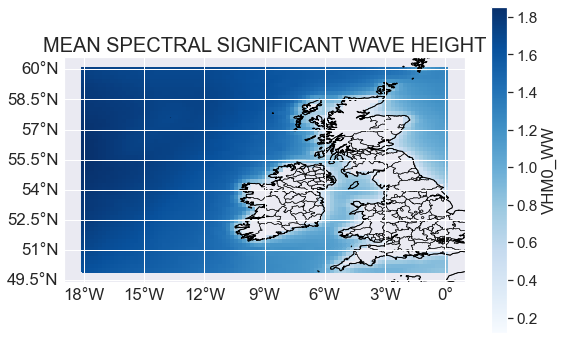

In [554]:
fig = plt.figure(figsize=(9,6))  # x,y(inches)
ax = plt.axes(projection=ccrs.PlateCarree())
graph=reanalysis.VHM0_WW.mean('time').plot(cmap=mpl.cm.Blues) 
ax.coastlines()
grid=ax.gridlines(draw_labels=True)
grid.top_labels = False
grid.right_labels = False
states = NaturalEarthFeature(category="cultural", scale="10m", facecolor="none", name="admin_1_states_provinces_shp")
ax.add_feature(states, linewidth=.5, edgecolor="black") 
plt.title('MEAN SPECTRAL SIGNIFICANT WAVE HEIGHT', size=20)



This plot show how mean spectral significant wave hieght is distributed over the selected area. In physical oceanography, the significant wave height is defined as the mean wave height (trough to crest) of the highest third of the waves. Most measuring devices estimate the significant wave height from a wave spectrum.

The farther from the coast the more, in average, the spectral wave height increases, instead the closerto the coast the more the spectral wave height decreases.

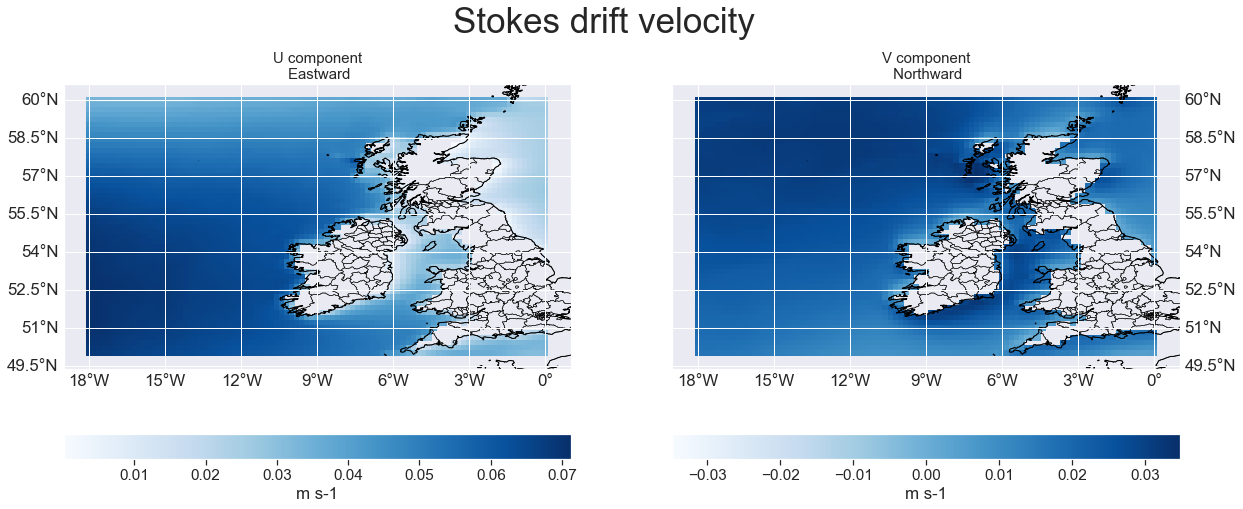

In [555]:
import matplotlib as mpl
fig = plt.figure(figsize=(20,8))
fig.suptitle('Stokes drift velocity', size=35)
subplots = (1,2)
n_panels = subplots[0] * subplots[1]
    
ax1 = fig.add_subplot(subplots[0], subplots[1], 1, projection=ccrs.PlateCarree())  
vsdx=reanalysis.VSDX.mean('time').plot(cmap=mpl.cm.Blues,  add_colorbar=False)

ax1.coastlines()
grid=ax1.gridlines(draw_labels=True)
grid.top_labels = False
grid.right_labels = False
states = NaturalEarthFeature(category="cultural", scale="10m", facecolor="none", name="admin_1_states_provinces_shp")
ax1.add_feature(states, linewidth=.5, edgecolor="black") 
ax1.set_title('U component\n Eastward', size=15)
#colorbar
bar=plt.colorbar(vsdx, orientation='horizontal').set_label(reanalysis.VSDX.units)



ax2 = fig.add_subplot(subplots[0], subplots[1], 2, projection=ccrs.PlateCarree())
vsdy=reanalysis.VSDY.mean('time').plot(cmap=mpl.cm.Blues, add_colorbar=False)

ax2.coastlines()
grid=ax2.gridlines(draw_labels=True)
grid.top_labels = False
grid.left_labels = False
states = NaturalEarthFeature(category="cultural", scale="10m", facecolor="none", name="admin_1_states_provinces_shp")
ax2.add_feature(states, linewidth=.5, edgecolor="black") 
ax2.set_title('V component\n Northward', size=15)
#colorbar
bar2=plt.colorbar(vsdy,orientation='horizontal').set_label(reanalysis.VSDY.units)


This plot show how mean stokes drift is distributed over the selected area. The Stokes drift is the difference in end positions, after a predefined amount of time (usually one wave period).

The meteorological convention is that U component is positive for a west to east flow (eastward) and the V component is positive for south to north flow (northward).

In fact in the left picture, stokes are lower on the right hand side. This probably beacuse island (Ireland and Great Britain) 
 stops eastward wind and stokes are lower than in open ocean. 
In the right picture,  the V component is more constant over space.



## ----------------------------------------------------------------------------------------------------------------------
### 2) BUOY NETWORK DATA

Real time meteorological and oceanographic data collected from the Irish moored Weather Buoy network of stations. 

Parameters collected include, DateTime (from 2001-02-06 to 2017-11-28) on an hourly frequency, Atmospheric Pressure (mbar), Air Temperature (degreeCelsius), DewPoint Temperature (degreeCelsius), Wind Speed (knots), Max Gust Wind Speed (knots), Wind Direction (degreeTrue), Sea Surface Temperature (degreeCelsius), Wave Period (seconds), Relative Humidity (%) and  Wave Height (metres).

The latter will be used to define extreme wave heights. 



Link for data download: https://data.world/marineinstitute/35a18e98-2706-4eb3-b064-46a8a66baf91

In [556]:
buoy = pd.read_csv("download-csv-3.csv")
buoy=buoy.drop(0, axis=0)
buoy.head()

,station_id,longitude,latitude,time,AtmosphericPressure,WindDirection,WindSpeed,Gust,WaveHeight,WavePeriod,MeanWaveDirection,Hmax,AirTemperature,DewPoint,SeaTemperature,RelativeHumidity,QC_Flag
1,M1,-11.2,53.1266,2001-02-06T13:00:00Z,967.6,270.0,21.98,33.1,NaN,NaN,NaN,NaN,8.9,NaN,9.0,NaN,1.0
2,M1,-11.2,53.1266,2001-02-06T14:00:00Z,969.8,270.0,23.93,35.0,NaN,NaN,NaN,NaN,8.5,NaN,9.0,NaN,1.0
3,M1,-11.2,53.1266,2001-02-06T15:00:00Z,972.0,270.0,19.07,31.1,NaN,NaN,NaN,NaN,8.9,NaN,9.0,NaN,1.0
4,M1,-11.2,53.1266,2001-02-06T16:00:00Z,973.6,270.0,15.95,25.3,NaN,NaN,NaN,NaN,9.1,NaN,9.0,NaN,1.0
5,M1,-11.2,53.1266,2001-02-06T18:00:00Z,976.4,270.0,12.06,19.5,NaN,NaN,NaN,NaN,8.8,NaN,9.0,NaN,1.0


In [557]:
#dtypes have to be adjusted
print(buoy.dtypes)

buoy['time']=pd.to_datetime(buoy['time'])
buoy['longitude']=pd.to_numeric(buoy['longitude'])
buoy['latitude']=pd.to_numeric(buoy['latitude'])
buoy.iloc[:,4:]=buoy.iloc[:,4:].astype(float)
buoy['station_id']=buoy['station_id'].astype(str)
buoy.dtypes

station_id              object
longitude               object
latitude                object
time                    object
AtmosphericPressure     object
WindDirection           object
WindSpeed               object
Gust                    object
WaveHeight              object
WavePeriod              object
MeanWaveDirection       object
Hmax                    object
AirTemperature          object
DewPoint                object
SeaTemperature          object
RelativeHumidity        object
QC_Flag                float64
dtype: object


station_id                          object
longitude                          float64
latitude                           float64
time                   datetime64[ns, UTC]
AtmosphericPressure                float64
WindDirection                      float64
WindSpeed                          float64
Gust                               float64
WaveHeight                         float64
WavePeriod                         float64
MeanWaveDirection                  float64
Hmax                               float64
AirTemperature                     float64
DewPoint                           float64
SeaTemperature                     float64
RelativeHumidity                   float64
QC_Flag                            float64
dtype: object

In [558]:
#describe varibales
buoy.describe()

,longitude,latitude,AtmosphericPressure,WindDirection,WindSpeed,Gust,WaveHeight,WavePeriod,MeanWaveDirection,Hmax,AirTemperature,DewPoint,SeaTemperature,RelativeHumidity,QC_Flag
count,613392.000000,613392.000000,599241.000000,588581.000000,557219.000000,510293.000000,538290.000000,540545.000000,130195.000000,123784.000000,605452.000000,389330.000000,556617.000000,515710.000000,613392.000000
mean,-9.377838,52.879674,1013.552494,206.033596,15.204662,21.320918,2.343247,6.140856,221.123707,3.118097,11.629430,8.600431,12.398436,82.373796,0.906880
std,3.288569,1.295569,12.327422,89.895692,6.997032,9.693340,1.553434,1.740916,79.128405,2.311975,2.951637,3.932127,2.315692,9.760950,0.290601
min,-15.881350,51.215958,909.900000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.264000,-30.000000,0.000000,0.000000,0.000000
25%,-10.548261,51.690426,1006.200000,150.000000,10.000000,14.089000,1.200000,5.000000,180.000000,1.465000,9.500000,5.800000,10.600000,75.000000,1.000000
50%,-9.999136,53.074820,1014.800000,220.000000,15.000000,20.000000,2.000000,6.000000,238.000000,2.539000,11.600000,8.900000,12.200000,83.000000,1.000000
75%,-6.704336,53.481003,1022.070000,271.000000,20.000000,27.000000,3.000000,7.000000,277.000000,4.102000,14.072000,11.600000,14.321000,90.000000,1.000000
max,-5.424046,54.999966,1046.400000,360.000000,76.506000,200.000000,17.200000,18.000000,359.000000,21.777000,26.172000,47.600000,24.200000,100.000000,1.000000


Wave Height variable is used to define target variable (extreme-non extreme waves). Form the variables description above, a maximum of 17.2 meter is observed in buoy stations. The 75-th quartile is of 3 meters and in average observed waves are of 2.34 meters height.

Text(0.5, 0.98, 'Waves height distribution across stations')

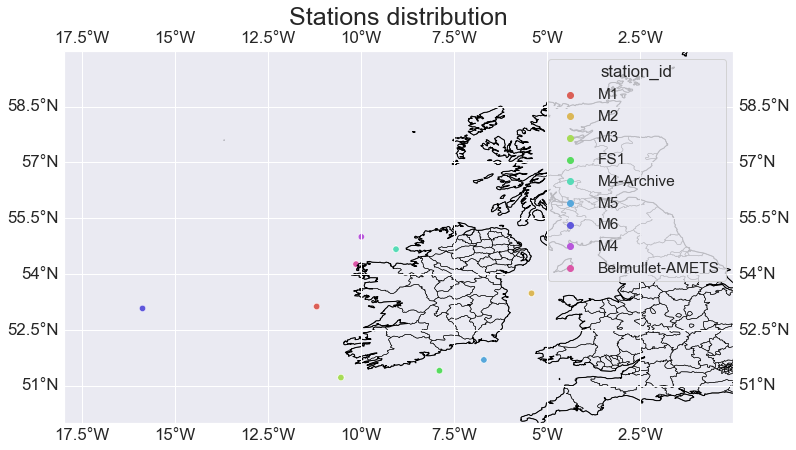

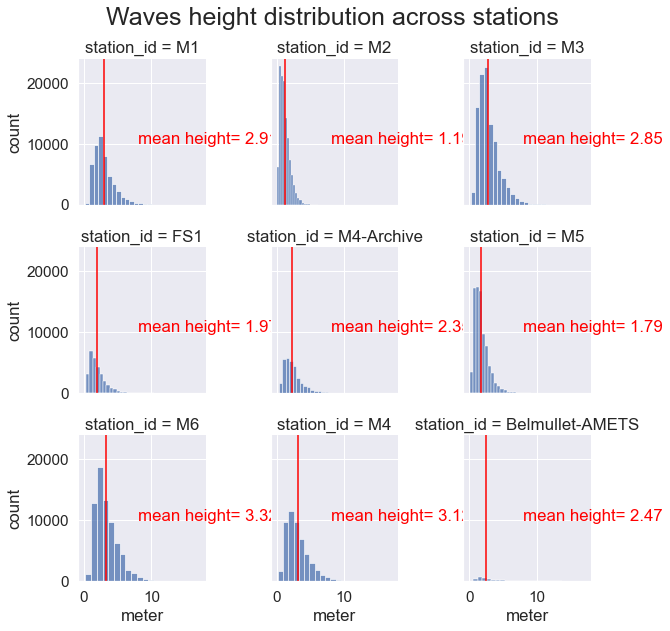

In [559]:
plt.figure(figsize = (12, 15))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_xlim([-18, 0])
ax.set_ylim([50, 60])
ax.gridlines(draw_labels=True)
states = NaturalEarthFeature(category="cultural", scale="10m", facecolor="none", name="admin_1_states_provinces_shp")
ax.add_feature(states, linewidth=.5, edgecolor="black") 
ax.coastlines()

sns.scatterplot(
        data=buoy, x='longitude', y='latitude', hue='station_id', s=40, palette='hls')

plt.title('Stations distribution', size=25)


g = sns.FacetGrid(buoy,   col="station_id", col_wrap=3,sharex=True)
g.map_dataframe(sns.histplot, x="WaveHeight", bins=20)
g = g.map(lambda y, **kw: plt.axvline(y.mean(), color="red"), 'WaveHeight')
g = g.map(lambda y, **kw: plt.text(x=8,y=10000,s='mean height= '+str('%.2f' % y.mean()), color="red"), 'WaveHeight')

g.set_xlabels('meter')
g.set_ylabels('count')
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Waves height distribution across stations', size=25)


The first plot above show the 9 stations distrbution over North Atlantic ocean, Celtic and Irish sea.

The second figure plot waves height variable distribution across stations. Different stations have different number of observation. For example Belmullet-AMETS buoy is the station with fewer data. 
Another important aspect is the mean height across stations which differ.

In fact mean height in Celtic and Irish sea (stations M2, M5 and FS1) is lower than in other statins which are in the Altantic Ocean.


Text(0.5, 0.98, 'Buoi time series by stations')

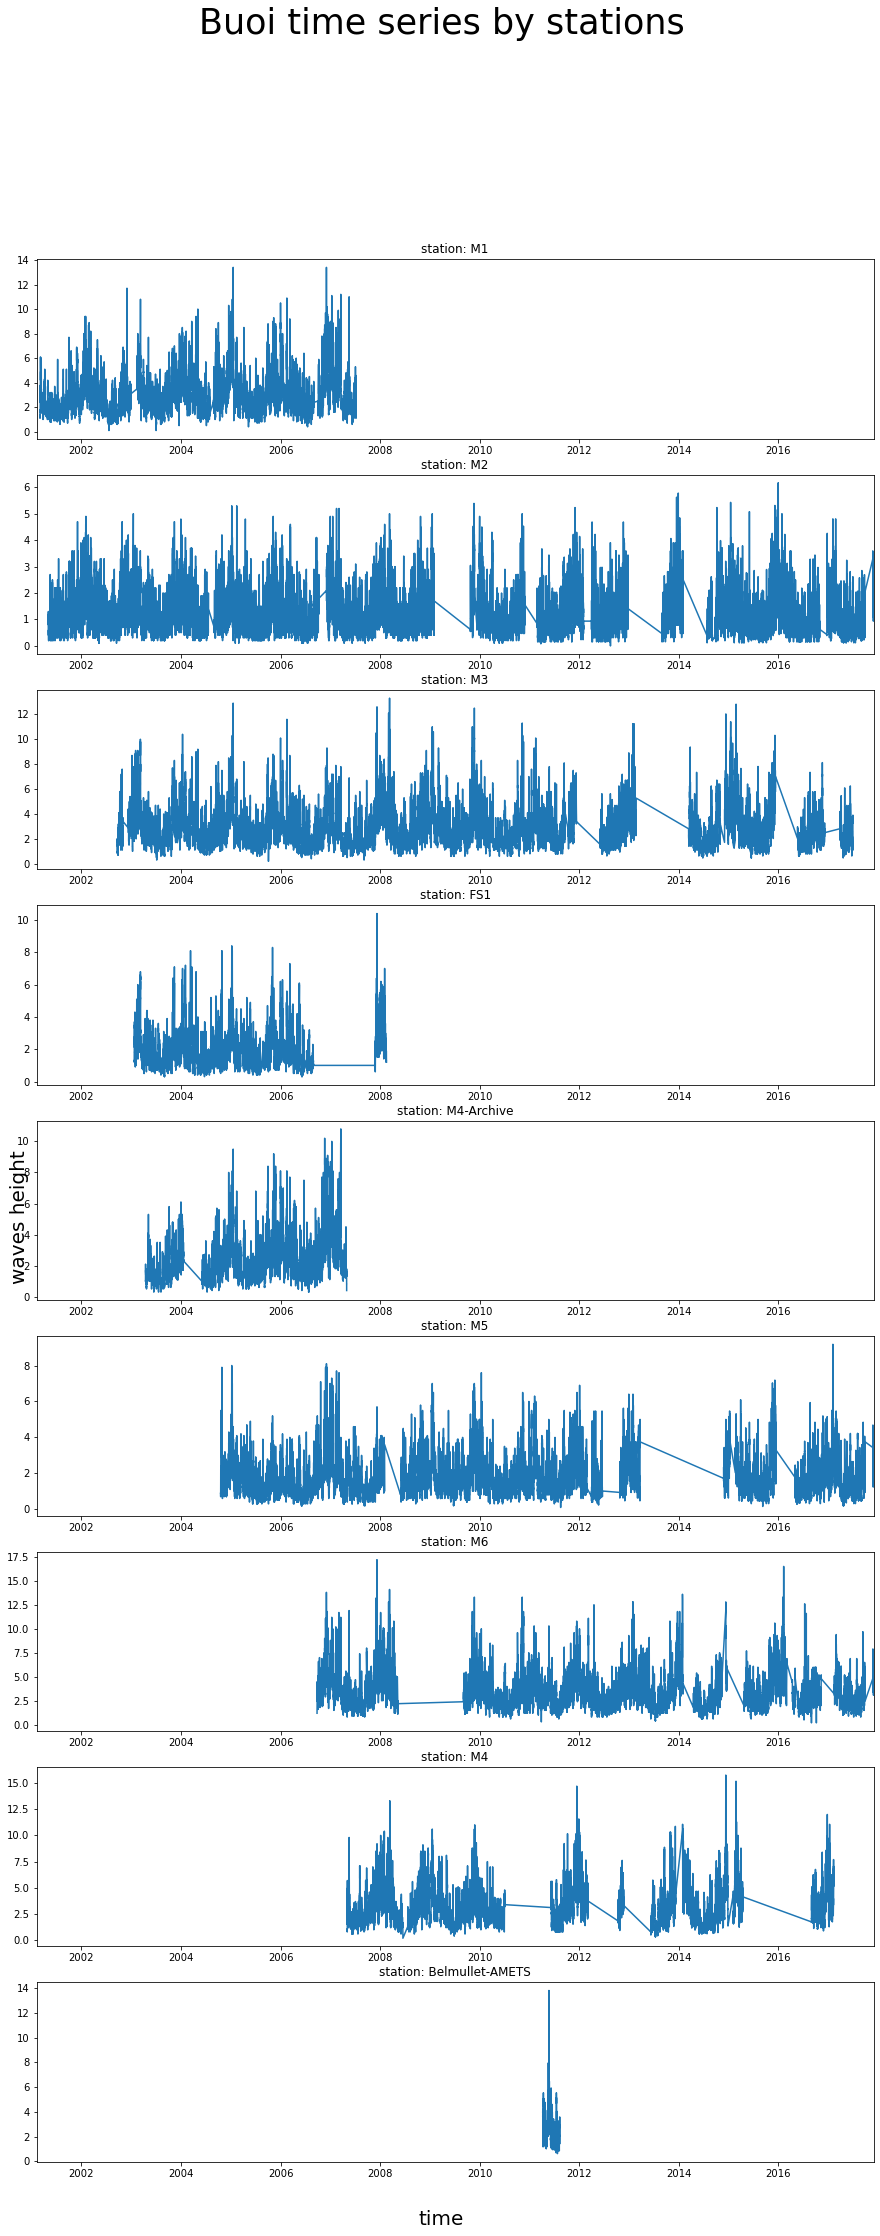

In [63]:
stations_list=buoy.station_id.unique() #list with stations names

#time series plot
fig, axs = plt.subplots(9,  figsize=(15,35))
for el in range(9):
    sns.lineplot(x='time',y='WaveHeight',data=buoy[buoy.station_id == stations_list[el]], ax=axs[el] ) 
    axs[el].set_title('station: '+str(stations_list[el]))
    axs[el].set_xlim(left=pd.Timestamp("2001-02-06 13:00:00+00:00"), right=pd.Timestamp("2017-11-28 10:00:00+00:00"))
    axs[el].set_xlabel('')
    axs[el].set_ylabel('')
fig.text( 0.5,0.1,'time', ha='center', size=20)
fig.text(0.1, 0.5, 'waves height', va='center', rotation='vertical', size=20)
fig.suptitle('Buoy time series by stations', size=35)

#fig.text(0.5,1, 'Buoi time series by stations', va='center', size=30)
#fig.suptitle('Buoi time series by stations')

### Data processing

1) Plot stations and grid to better understand dataset creation

2) Find nearest point between grid point and stations point

2) Resample buoy data from 1h to 3h

3) Fix some variables format for merging purpose and drop null values 

4) Merge information of reanalysis and buoy to have a unified dataset.

5) Define Target variable

6) Train - Test Split

7) Scale data

In [28]:
reanalysis_df=reanalysis.to_dataframe().reset_index() #from xarray to dataframe
reanalysis_df = reanalysis_df[reanalysis_df.time <= '2017-11-28'] #select dates
reanalysis_df.head()

,latitude,longitude,time,VHM0_WW,VMDR_SW2,VMDR,VMDR_SW1,VTM10,VPED,VTPK,VTM02,VHM0_SW1,VMDR_WW,VTM01_SW2,VSDX,VTM01_SW1,VSDY,VHM0,VTM01_WW,VHM0_SW2
0,60.0,-18.0,2015-01-01 00:00:00,3.14,264.570007,208.270004,181.270004,9.87,187.5,11.740000,7.90,3.81,241.669998,13.270000,0.15,10.42,0.13,5.06,6.88,0.94
1,60.0,-18.0,2015-01-01 03:00:00,3.43,261.350006,215.669998,180.550003,9.88,187.5,11.559999,7.95,3.31,232.750000,13.009999,0.16,10.83,0.14,5.10,7.19,1.34
2,60.0,-18.0,2015-01-01 06:00:00,2.98,273.729980,220.489990,202.429993,10.20,187.5,11.660000,8.17,3.93,230.869995,9.020000,0.15,11.37,0.14,5.24,6.68,1.77
3,60.0,-18.0,2015-01-01 09:00:00,2.30,225.270004,225.830002,257.089996,10.80,247.5,11.980000,8.61,3.46,229.949997,11.190000,0.14,11.74,0.13,5.43,5.86,1.81
4,60.0,-18.0,2015-01-01 12:00:00,2.03,24.710007,230.440002,229.940002,11.34,247.5,12.690000,8.92,5.21,233.229996,11.509999,0.15,11.36,0.12,5.60,5.53,0.09


In [46]:
#extract latitude and longitude list for plotting and data processing purpose
lat_list=reanalysis_df.latitude.unique()
lon_list=reanalysis_df.longitude.unique()

buoy_lat_list=buoy.latitude.unique()
buoy_lon_list=buoy.longitude.unique()


#### Plot stations and grid

Text(0.5, 1.0, 'BUOY NETWORK AND REANALYSIS GRID')

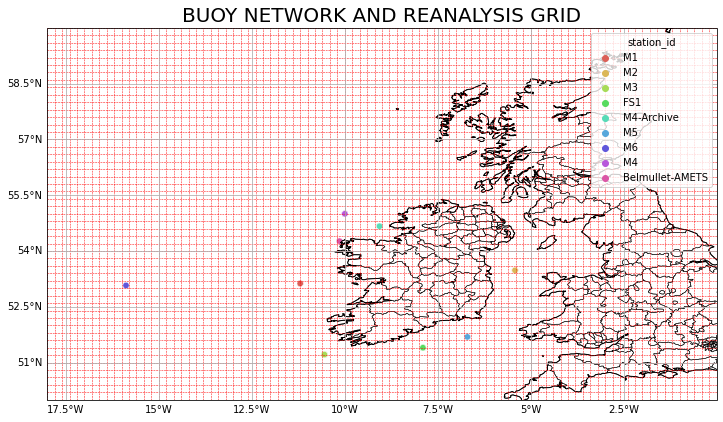

In [105]:
#plot stations and grid points
fig, ax = plt.subplots(figsize = (12, 15)) 
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_xlim([-18, 0])
ax.set_ylim([50, 60])
grid=ax.gridlines(draw_labels=True)
grid.top_labels = False
grid.right_labels = False
states = NaturalEarthFeature(category="cultural", scale="10m", facecolor="none", name="admin_1_states_provinces_shp")
ax.add_feature(states, linewidth=.5, edgecolor="black") 
#reanlysis_gdf.plot(color='blue',ax=ax)
sns.scatterplot(
        data=buoy, x='longitude', y='latitude', hue='station_id', s=40, palette='hls')
plt.hlines(y=lat_list, xmin=-18, xmax=0, colors='red', linestyles='--', linewidth=0.5)
plt.vlines(x=lon_list, ymin=50, ymax=60,colors='red', linestyles='--', linewidth=0.5)
plt.title('BUOY NETWORK AND REANALYSIS GRID', size=20)

#### Prepare reanalysis data

In [47]:
#to reduce df dimension, keep only latute and longitude info closest to each buoy

lon_closest=[]
for el in buoy_lon_list:
    closest=min(lon_list, key=lambda x:abs(x-el))
    lon_closest.append(closest)
    
lat_closest=[]
for el in buoy_lat_list:
    closest=min(lat_list, key=lambda x:abs(x-el))
    lat_closest.append(closest)
    
reanalysis_df_reduced= reanalysis_df[(reanalysis_df.latitude.isin(lat_closest))&(reanalysis_df.longitude.isin(lon_closest)) ]
#create gdf to use shapely functionality
reanalysis_df_reduced=gpd.GeoDataFrame(reanalysis_df_reduced.drop(['longitude', 'latitude'], axis=1)
    ,crs={'init': 'epsg:4326'}, geometry=gpd.points_from_xy(reanalysis_df_reduced.longitude, reanalysis_df_reduced.latitude))
reanalysis_df_reduced

,time,VHM0_WW,VMDR_SW2,VMDR,VMDR_SW1,VTM10,VPED,VTPK,VTM02,VHM0_SW1,VMDR_WW,VTM01_SW2,VSDX,VTM01_SW1,VSDY,VHM0,VTM01_WW,VHM0_SW2,geometry
19440144,2015-01-01 00:00:00,3.49,276.059998,220.529999,183.949997,9.110000,202.5,10.380000,7.550000,2.66,226.660004,10.840000,0.15,10.300000,0.14,4.72,7.29,1.15,POINT (-15.79999 55.00000)
19440145,2015-01-01 03:00:00,1.85,14.889999,226.059998,225.709991,9.280000,202.5,10.389999,7.660000,4.09,227.350006,11.349999,0.13,9.520000,0.12,4.49,5.29,0.07,POINT (-15.79999 55.00000)
19440146,2015-01-01 06:00:00,0.32,350.559998,232.270004,222.830002,9.679999,247.5,10.639999,8.080000,3.97,239.300003,10.960000,0.09,8.849999,0.08,4.31,2.37,0.91,POINT (-15.79999 55.00000)
19440147,2015-01-01 09:00:00,0.35,296.019989,238.919998,215.500000,10.139999,262.5,10.950000,8.270000,3.41,230.570007,10.520000,0.09,8.780000,0.07,4.25,2.44,2.09,POINT (-15.79999 55.00000)
19440148,2015-01-01 12:00:00,1.30,176.600006,245.549988,258.200012,10.520000,262.5,11.559999,8.099999,3.78,245.070007,7.610000,0.13,11.030000,0.08,4.38,4.43,1.78,POINT (-15.79999 55.00000)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34594260,2017-11-27 12:00:00,2.55,267.049988,270.679993,241.440002,7.070000,262.5,8.150000,5.770000,0.70,276.839996,10.800000,0.17,9.780000,-0.04,2.81,6.07,0.50,POINT (-5.39999 51.20000)
34594261,2017-11-27 15:00:00,2.44,266.839996,272.059998,242.209991,6.960000,262.5,8.050000,5.660000,0.85,279.130005,10.889999,0.17,9.090000,-0.04,2.73,5.90,0.49,POINT (-5.39999 51.20000)
34594262,2017-11-27 18:00:00,1.94,11.889999,275.190002,251.320007,6.890000,262.5,7.990000,5.580000,1.70,293.929993,4.880000,0.14,7.830000,-0.07,2.58,5.26,0.12,POINT (-5.39999 51.20000)
34594263,2017-11-27 21:00:00,2.06,9.440002,279.540009,249.440002,6.750000,262.5,7.890000,5.440000,1.43,294.000000,5.560000,0.14,7.920000,-0.08,2.51,5.36,0.16,POINT (-5.39999 51.20000)


<class 'shapely.geometry.multipoint.MultiPoint'>


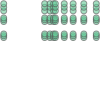

In [48]:
#generate a grid with unique values and tranform it in gdf to use geometry functions (ex. unuary union and nearest)
grid=reanalysis_df_reduced.geometry.unique()
df_grid=pd.DataFrame(grid, columns=['geometry'])
geodf_grid=gpd.GeoDataFrame(df_grid)
search_point = geodf_grid.geometry.unary_union
print(type(search_point))
search_point

#### Prepare buoy data

In [49]:
#resample from hourly data to 3h time period
buoy=buoy.set_index(buoy.time)
buoy_res=buoy.resample('3h').mean()
buoy_res.describe()

,longitude,latitude,AtmosphericPressure,WindDirection,WindSpeed,Gust,WaveHeight,WavePeriod,MeanWaveDirection,Hmax,AirTemperature,DewPoint,SeaTemperature,RelativeHumidity,QC_Flag
count,48574.000000,48574.000000,48572.000000,48567.000000,48561.000000,48456.000000,48304.000000,48305.000000,19443.000000,18066.000000,48569.000000,44104.000000,48546.000000,47739.000000,48574.000000
mean,-9.331285,52.918408,1013.341109,205.421698,15.078678,21.114525,2.353287,6.171093,218.730763,3.087799,11.492251,8.738674,12.296664,82.475118,0.894765
std,0.915840,0.317808,12.056815,68.895906,5.618164,7.887502,1.202776,1.132117,60.936888,1.773242,2.816721,3.623845,2.223161,7.727005,0.306851
min,-15.881350,51.215958,954.144167,0.000000,0.000000,2.000000,0.156000,2.773333,1.666667,0.000000,2.600000,-4.166667,7.272667,47.396000,0.000000
25%,-9.711426,52.745293,1006.043589,160.000000,10.957000,15.333333,1.471482,5.333333,189.000000,1.790333,9.347059,6.133333,10.223077,76.835722,1.000000
50%,-9.502217,52.892435,1014.475578,214.166667,14.450933,20.030188,2.087500,6.000000,223.777778,2.690944,11.279714,8.980000,11.949486,82.869125,1.000000
75%,-8.588669,53.192937,1021.706016,256.666667,18.666667,25.857143,2.948458,6.866667,258.500000,3.987833,13.986667,11.550000,14.347335,88.555556,1.000000
max,-5.424046,54.999966,1044.105556,360.000000,42.666667,74.250000,10.325667,13.320333,358.333333,15.006667,22.600000,24.200000,18.305143,99.609000,1.000000


In [50]:
#transform to geodataframe to use geometry functions
gdf_buoy_res = gpd.GeoDataFrame(
    buoy_res.drop(['longitude', 'latitude'], axis=1),
    crs={'init': 'epsg:4326'},
    geometry=[Point(xy) for xy in zip( buoy_res.longitude,buoy_res.latitude)])
gdf_buoy_res

,AtmosphericPressure,WindDirection,WindSpeed,Gust,WaveHeight,WavePeriod,MeanWaveDirection,Hmax,AirTemperature,DewPoint,SeaTemperature,RelativeHumidity,QC_Flag,geometry
time,,,,,,,,,,,,,,
2001-02-06 12:00:00+00:00,968.700000,270.000000,22.955000,34.050000,NaN,NaN,NaN,NaN,8.700000,NaN,9.000000,NaN,1.0,POINT (-11.20000 53.12660)
2001-02-06 15:00:00+00:00,972.800000,270.000000,17.510000,28.200000,NaN,NaN,NaN,NaN,9.000000,NaN,9.000000,NaN,1.0,POINT (-11.20000 53.12660)
2001-02-06 18:00:00+00:00,977.600000,265.000000,11.575000,18.500000,NaN,NaN,NaN,NaN,8.800000,NaN,9.000000,NaN,1.0,POINT (-11.20000 53.12660)
2001-02-06 21:00:00+00:00,980.666667,300.000000,9.663333,16.200000,NaN,NaN,NaN,NaN,8.133333,NaN,9.000000,NaN,1.0,POINT (-11.20000 53.12660)
2001-02-07 00:00:00+00:00,982.600000,335.000000,7.490000,14.600000,NaN,NaN,NaN,NaN,8.000000,NaN,9.000000,NaN,1.0,POINT (-11.20000 53.12660)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-11-27 21:00:00+00:00,1015.556833,255.777778,20.307917,27.512750,2.590889,5.882778,NaN,2.969000,9.387083,4.800000,12.332417,74.994833,0.0,POINT (-9.50222 53.31155)
2017-11-28 00:00:00+00:00,1016.279583,332.000000,19.427667,27.011917,2.510444,5.752667,NaN,2.773500,8.996750,5.100000,12.292583,74.070500,0.0,POINT (-9.50222 53.31155)
2017-11-28 03:00:00+00:00,1016.650917,268.333333,19.418417,26.969833,2.507000,5.883000,NaN,2.656333,8.756417,4.833333,12.341250,75.313917,0.0,POINT (-9.50222 53.31155)


In [51]:
#remove nan from target value
gdf_buoy_res = gdf_buoy_res[gdf_buoy_res['WaveHeight'].notna()]


#### Find closest point of the grid to the buoy

In [52]:

def near(point, pts=search_point):
     # find the nearest point and return the corresponding Place value
     nearest = geodf_grid.geometry == nearest_points(point, pts)[1]
     return geodf_grid[nearest].geometry.values[0]

gdf_buoy_res['closest'] = gdf_buoy_res.apply(lambda row: near(row.geometry), axis=1)
gdf_buoy_res.head(5)

,AtmosphericPressure,WindDirection,WindSpeed,Gust,WaveHeight,WavePeriod,MeanWaveDirection,Hmax,AirTemperature,DewPoint,SeaTemperature,RelativeHumidity,QC_Flag,geometry,closest
time,,,,,,,,,,,,,,,
2001-03-02 15:00:00+00:00,998.800000,125.000000,6.515000,12.650000,1.400000,7.0,NaN,NaN,4.500000,NaN,9.1,NaN,1.0,POINT (-11.20000 53.12660),POINT (-11.20001220703125 53.20000076293945)
2001-03-02 18:00:00+00:00,998.400000,143.333333,6.030000,11.666667,1.366667,7.0,NaN,NaN,4.733333,NaN,9.1,NaN,1.0,POINT (-11.20000 53.12660),POINT (-11.20001220703125 53.20000076293945)
2001-03-02 21:00:00+00:00,998.133333,196.666667,5.706667,9.700000,1.300000,7.0,NaN,NaN,4.966667,NaN,9.1,NaN,1.0,POINT (-11.20000 53.12660),POINT (-11.20001220703125 53.20000076293945)
2001-03-03 00:00:00+00:00,997.666667,230.000000,5.060000,9.066667,1.300000,8.0,NaN,NaN,5.300000,NaN,9.1,NaN,1.0,POINT (-11.20000 53.12660),POINT (-11.20001220703125 53.20000076293945)
2001-03-03 03:00:00+00:00,997.000000,275.000000,6.030000,15.550000,1.300000,7.0,NaN,NaN,5.000000,NaN,9.1,NaN,1.0,POINT (-11.20000 53.12660),POINT (-11.20001220703125 53.20000076293945)


In [53]:
#tranform shapely point back to latitude and longiutude
gdf_buoy_res['lon_near'] = gdf_buoy_res.closest.apply(lambda p: p.x)
gdf_buoy_res['lat_near'] = gdf_buoy_res.closest.apply(lambda p: p.y)


reanalysis_df_reduced['lon_near'] = reanalysis_df_reduced.geometry.apply(lambda p: p.x)
reanalysis_df_reduced['lat_near'] = reanalysis_df_reduced.geometry.apply(lambda p: p.y)


In [54]:
#keep only variable of interest and reset index to merge
df_waveheight= gdf_buoy_res[['WaveHeight','lat_near','lon_near']]
df_waveheight=df_waveheight.reset_index()
df_waveheight = df_waveheight[df_waveheight.time >= '2015-01-01 00:00:00+00:00'] #select dates


In [55]:
#fix timestamp to merge
reanalysis_df_reduced['time'] = pd.to_datetime(reanalysis_df_reduced['time'], utc = True)

#### Merge the 2 dataframe on time, latitude and longitude

In [56]:
final=df_waveheight.merge(reanalysis_df_reduced, right_on=['time', 'lat_near', 'lon_near'], left_on=['time','lat_near','lon_near'],how='inner')

In [57]:
final.isnull().sum(axis = 0)

time             0
WaveHeight       0
lat_near         0
lon_near         0
VHM0_WW       1726
VMDR_SW2      1726
VMDR          1726
VMDR_SW1      1726
VTM10         1726
VPED          1726
VTPK          1726
VTM02         1726
VHM0_SW1      1726
VMDR_WW       1726
VTM01_SW2        0
VSDX          1726
VTM01_SW1     1726
VSDY          1726
VHM0          1726
VTM01_WW      1726
VHM0_SW2      1726
geometry         0
dtype: int64

In [58]:
#remove nan values beacouse some models can't handle nan
final = final[final['VHM0_WW'].notna()]

In [59]:
final.head()

,time,WaveHeight,lat_near,lon_near,VHM0_WW,VMDR_SW2,VMDR,VMDR_SW1,VTM10,VPED,...,VHM0_SW1,VMDR_WW,VTM01_SW2,VSDX,VTM01_SW1,VSDY,VHM0,VTM01_WW,VHM0_SW2,geometry
103,2015-01-13 21:00:00+00:00,4.700833,53.200001,-9.0,0.23,262.489990,258.880005,262.179993,7.02,262.5,...,0.48,234.750000,12.400000,0.03,4.71,0.02,0.66,2.11,0.35,POINT (-9.00000 53.20000)
104,2015-01-14 00:00:00+00:00,4.635667,53.200001,-9.0,0.22,264.209991,257.059998,259.589996,7.10,262.5,...,0.45,227.850006,13.530000,0.03,4.66,0.02,0.62,2.04,0.30,POINT (-9.00000 53.20000)
105,2015-01-14 03:00:00+00:00,4.668167,53.200001,-9.0,0.28,263.899994,258.269989,262.880005,6.65,262.5,...,0.50,235.399994,13.509999,0.04,4.91,0.02,0.69,2.23,0.29,POINT (-9.00000 53.20000)
106,2015-01-14 06:00:00+00:00,5.084667,53.200001,-9.0,0.33,264.489990,258.100006,264.279999,6.49,262.5,...,0.55,233.330002,14.020000,0.04,4.97,0.03,0.76,2.37,0.27,POINT (-9.00000 53.20000)
107,2015-01-14 09:00:00+00:00,4.570333,53.200001,-9.0,0.28,263.209991,254.299988,259.239990,6.62,262.5,...,0.55,213.119995,13.460000,0.03,4.69,0.03,0.74,2.19,0.30,POINT (-9.00000 53.20000)


In [60]:
#save
#final.to_csv('final.csv')
#read
#final=pd.read_csv('final.csv')

#### Define Target variable

In [61]:
quantile=final.WaveHeight.quantile(0.90)
quantile

3.5875666666666666

In [62]:
#transform target variballes in 0-1
final.WaveHeight.loc[(final.WaveHeight < quantile)] = 0
final.WaveHeight.loc[(final.WaveHeight >= quantile)] = 1


In [63]:
print('TARGET DISTRIBUTION \n-----------------------\n'+str(final.WaveHeight.value_counts()/final.shape[0]*100))

print( '-----------------------\nclass 0: Normal Waves\nclass 1: Extreme Waves ')

TARGET DISTRIBUTION 
-----------------------
0.0    89.995258
1.0    10.004742
Name: WaveHeight, dtype: float64
-----------------------
class 0: Normal Waves
class 1: Extreme Waves 


In [64]:
#remove column that will not be used for classification
final.pop('time')
final.pop('lat_near')
final.pop('lon_near')
final.pop('geometry')

103      POINT (-9.00000 53.20000)
104      POINT (-9.00000 53.20000)
105      POINT (-9.00000 53.20000)
106      POINT (-9.00000 53.20000)
107      POINT (-9.00000 53.20000)
                   ...            
8048    POINT (-10.00000 53.40000)
8049    POINT (-10.00000 53.40000)
8050    POINT (-10.00000 53.40000)
8051    POINT (-10.00000 53.40000)
8052    POINT (-10.00000 53.40000)
Name: geometry, Length: 6327, dtype: geometry

#### Train Test Validation Split

In [65]:
np.random.seed(5)
#(train+validation)-test split
train,test=train_test_split(final, test_size=0.2, stratify=final.WaveHeight)
#train validation split
train,validation=train_test_split(train, test_size=0.2, stratify=train.WaveHeight)

In [66]:
print('train shape: '+str(train.shape))
print('validation shape: '+str(validation.shape))
print('test shape: '+str(test.shape))

train shape: (4048, 18)
validation shape: (1013, 18)
test shape: (1266, 18)


#### Scale data and Binarize target value

In [67]:
#extract features and labels 
labels_nn = train.pop('WaveHeight')
labels_test_nn=test.pop('WaveHeight')
labels_valid_nn=validation.pop('WaveHeight')


#Standardize features by removing the mean and scaling to unit variance
X_scaled = StandardScaler().fit_transform(train)
X_scaled_test = StandardScaler().fit_transform(test)
X_scaled_valid = StandardScaler().fit_transform(validation)


# generate dummy for Neural Network classification
Y = LabelBinarizer().fit_transform(labels_nn)
Y_test = LabelBinarizer().fit_transform(labels_test_nn)
Y_valid = LabelBinarizer().fit_transform(labels_valid_nn)



### Modelling

1) Neural Network

2) Logistic Regression

3) Support Vector Machines

4) Decision Trees

5) Random Forest

6) Naive Bayes


Compare model using Accuracy and Precison metrics.
Since target class is unbalanced, precision help in deciding for the best model since it penalize false positive.
In this case is very important to minimize false positive, because the risk in classifying an Extreme Waves (dangerous event) as a Normal Waves  is higher than making the opposite mistake (Normal Waves classifyied as Extreme).

#### Train Neural Network

In [68]:
import keras
#define model metrics
METRICS = [ 
      keras.metrics.BinaryAccuracy(name='accuracy'),
keras.metrics.Precision(name='precision')]

EPOCHS = 100
BS = 300

#set early stopping
early_stop = EarlyStopping(monitor='precision', min_delta=0.000000001, patience=10, mode='max', restore_best_weights=True)

In [69]:
#check input dim
X_scaled.shape

(4048, 17)

In [78]:
#single layer perceptron
def Model_NN(optimizer='RMSprop', init_mode='random_normal', metrics=METRICS):
    model = Sequential()
    model.add(Dense(units=9, activation='ReLU', input_dim=17, kernel_initializer=init_mode))
    model.add(Dense(units=5, activation='ReLU', kernel_initializer=init_mode))
    model.add(Dense(units=1, activation='sigmoid', kernel_initializer=init_mode))
    # compile model
    model.compile(loss='binary_crossentropy', 
                  optimizer=optimizer, 
                  metrics=metrics)

    return model

In [79]:
%%time
model_NN= Model_NN(optimizer='RMSprop', init_mode='random_normal',  metrics=METRICS)

model_history =model_NN.fit(
    X_scaled,
    Y,
    batch_size=BS,
    epochs=EPOCHS,
    callbacks=[early_stop],
    validation_data=(X_scaled_valid, Y_valid),)

Epoch 1/100
14/14 [==============================] - 3s 61ms/step - loss: 0.6869 - accuracy: 0.8975 - precision: 0.0883 - val_loss: 0.6808 - val_accuracy: 0.8975 - val_precision: 0.0883
Epoch 2/100
14/14 [==============================] - 0s 5ms/step - loss: 0.6759 - accuracy: 0.8976 - precision: 0.0883 - val_loss: 0.6696 - val_accuracy: 0.8976 - val_precision: 0.0883
Epoch 3/100
14/14 [==============================] - 0s 6ms/step - loss: 0.6638 - accuracy: 0.8977 - precision: 0.0883 - val_loss: 0.6558 - val_accuracy: 0.8977 - val_precision: 0.0883
Epoch 4/100
14/14 [==============================] - 0s 7ms/step - loss: 0.6487 - accuracy: 0.8978 - precision: 0.0883 - val_loss: 0.6389 - val_accuracy: 0.8978 - val_precision: 0.0883
Epoch 5/100
14/14 [==============================] - 0s 5ms/step - loss: 0.6303 - accuracy: 0.8978 - precision: 0.0883 - val_loss: 0.6187 - val_accuracy: 0.8979 - val_precision: 0.0883
Epoch 6/100
14/14 [==============================] - 0s 5ms/step - loss: 0

loss on test:  0.19279661774635315
accuracy on test:  0.912662148475647
precision on test:  0.7952587008476257
-----------------------------


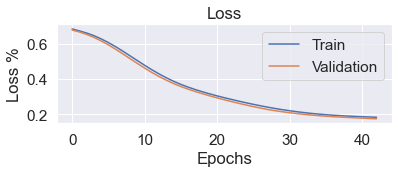

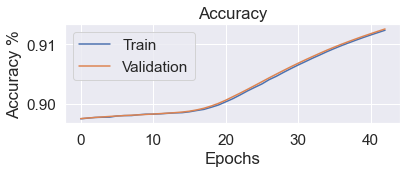

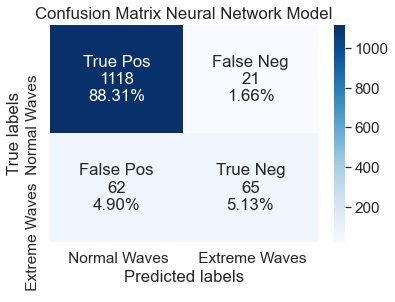

In [80]:
#plot results
from sklearn.metrics import confusion_matrix
model_results = model_NN.evaluate(X_scaled_test, Y_test,
                                  batch_size=BS, verbose=0)

for name, value in zip(model_NN.metrics_names, model_results):
                                  
  print(name, 'on test: ', value)
print('-----------------------------')
y_pred=model_NN.predict(X_scaled_test)
confusion_matrix = confusion_matrix(Y_test, np.rint(y_pred))
plot_loss_accuracy(model_history)
plot_confusion_matrix(confusion_matrix, 'Confusion Matrix Neural Network Model')

In [81]:
models = {}

# Logistic Regression
from sklearn.linear_model import LogisticRegression
models['Logistic Regression'] = LogisticRegression()

# Support Vector Machines
from sklearn.svm import LinearSVC
models['Support Vector Machines'] = LinearSVC()

# Decision Trees
from sklearn.tree import DecisionTreeClassifier
models['Decision Trees'] = DecisionTreeClassifier()

# Random Forest
from sklearn.ensemble import RandomForestClassifier
models['Random Forest'] = RandomForestClassifier()

# Naive Bayes
from sklearn.naive_bayes import GaussianNB
models['Naive Bayes'] = GaussianNB()

# K-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier
models['K-Nearest Neighbor'] = KNeighborsClassifier()

In [82]:
from sklearn.metrics import accuracy_score, precision_score

accuracy, precision = {}, {}

for key in models.keys():
    
    # Fit the classifier model
    models[key].fit(X_scaled, labels_nn)
    
    # Prediction 
    predictions = models[key].predict(X_scaled_test)
    
    # Calculate Accuracy, Precision and Recall Metrics
    accuracy[key] = accuracy_score(predictions,labels_test_nn)
    precision[key] = precision_score(predictions, labels_test_nn)


In [83]:

df_model = pd.DataFrame(index=models.keys(), columns=['Accuracy', 'Precision'])
df_model['Accuracy'] = accuracy.values()
df_model['Precision'] = precision.values()

df_model.loc['Neural Network'] = [model_results[1], model_results[2]]
df_model

,Accuracy,Precision
Logistic Regression,0.937599,0.511811
Support Vector Machines,0.938389,0.480315
Decision Trees,0.933649,0.669291
Random Forest,0.950237,0.677165
Naive Bayes,0.898104,0.803150
K-Nearest Neighbor,0.937599,0.614173
Neural Network,0.912662,0.795259


In [90]:
print(df_model.mean(axis=1))
print(df_model.mean())


Logistic Regression        0.724705
Support Vector Machines    0.709352
Decision Trees             0.801470
Random Forest              0.813701
Naive Bayes                0.850627
K-Nearest Neighbor         0.775886
Neural Network             0.853960
dtype: float64
Accuracy     0.929748
Precision    0.650166
dtype: float64
0.7899573557433999


Best model  obtained is with Neural Network considering a tradeoff between accuracy and precision. Mean accuracy reacched from all model is of 0.92% and mean precision of 0.65%)